# MIE1613 Project Experiment #8 - Exploring input uncertainty in MLE on embodied emissions
Here I use the simulation to further answer question 1: what kind of uncertainty is associated with the maximum likelyhood inference on the housing input data?

In [1]:
# Import Libraries
# Data
import numpy as np
import scipy as sp
from scipy import stats
import pandas as pd
import random

import re
from copy import deepcopy
#from tqdm import tqdm
import tqdm.notebook as tq

#Viz
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec
import seaborn as sns
sns.set(font='Helvetica') # Futura? Calibri Light? 
sns.set_style("white")
sns.set_theme(style='ticks')
sns.set_context('talk')

c:\Users\Keagan Rankin\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
c:\Users\Keagan Rankin\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


## Import
want the input data for housing. We can look at max, min, and most likely factors. The years are not necessary as it is just multiplicative scaling

In [2]:
from packages.project_package.mie_importer import *
from packages.project_package.mie_simulation import *

In [216]:
# Emissions data
Impr = MIEImporter()
Impr.factor_range = 'likely'

Impr.e_path = 'data/input_data/embodied_'+Impr.factor_range+'_conservative.csv'
Impr.o_path = 'data/input_data/operational_intensity_2020_2050_conservative.csv'
embodied_data, operational_data = Impr.import_emission_data()
starts_data_hg10 = pd.read_csv('data/input_data/starts_samplepaths_bayesian_hg10.csv', index_col=0)

Importer created. Change self.factor_range for sensitivity analysis before importing.


## Input Parameters
Pick method from textbook/paper on quercus according to Vahid? My thought was boostrapping over the input data and fitting MLE many times to get a distribution of the parameters. <br>
I have a nice function in the simulation object that fits MLE for all housing types that I can reuse, but it returns a three parameter fit and I only want two parameters -> $\mu$ and $\sigma$ = `log(scale)` and `shape`

In [156]:
# Isolating the 2016 data
emdata2030 = embodied_data.loc[embodied_data['year'] == 2030,:]
emdata2030

,GHG Quantity 1 Most Likely,Units,mm_split_labels,labels_general,ghg_per_unit,year
Building Key,,,,,,
1,8.162223e+04,1,Single Family,Single Family,81622.23285,2030
2,2.854891e+04,1,Single Family,Single Family,28548.91288,2030
3,4.946342e+04,1,Single Family,Single Family,49463.42403,2030
4,2.881597e+04,1,Single Family,Single Family,28815.97500,2030
7,4.555010e+04,1,Single Family,Single Family,45550.10087,2030
...,...,...,...,...,...,...
86,4.676437e+06,210,Mid High Rise,Mid High Rise,22268.74780,2030
87,1.107204e+07,545,Mid High Rise,Mid High Rise,20315.66555,2030
90,5.570730e+06,363,Mid High Rise,Mid High Rise,15346.36249,2030


In [217]:
# init simulator
Simr = MIESimulation()
Simr.nlmh = [0.4, 0.3, 0.3]
Simr.year=2030
Simr.e_data = embodied_data
Simr.o_data = operational_data

Sim object created. Initialize self.e_data and self.o_data


(0.37458268993727106, 0, 53839.91453158643)


<Axes: ylabel='Density'>

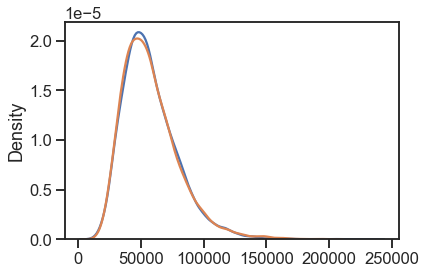

In [218]:
# test -> the base gives three parameters, whereas you can
#np.random.seed(Simr.seed)
# also ask for just two (mean+std). See if they correspond
fig, ax = plt.subplots()
# three params
p = Simr.embodied_fitter_mle(emdata2030)
params = p['Single Family']
sns.kdeplot(stats.lognorm.rvs(*params, size=10000), ax=ax)

# two params
foodata = emdata2030.loc[emdata2030['mm_split_labels'] == 'Single Family']
paramslo = stats.lognorm.fit(foodata['ghg_per_unit'], floc=0)
print(paramslo)
sns.kdeplot(stats.lognorm.rvs(*paramslo, size=10000), ax=ax)

Create a function which returns this mean and st.dev for each housing type on the overall data

In [219]:
def lognorm_fit_two_param(data):
    parameters = {}
    for house_type in Simr.lmh:
        d_col = 'ghg_per_unit'
        data_i = data.loc[data['labels_general']==house_type][d_col]
        parameters[house_type] = stats.lognorm.fit(data_i, floc=0)

    return parameters

In [220]:
lognorm_fit_two_param(emdata2030)

{'Single Family': (0.37458268993727106, 0, 53839.91453158643),
 'Missing Middle': (0.4816911358239958, 0, 20778.528726891458),
 'Mid High Rise': (0.3109002813989817, 0, 20916.939174096482)}

## Uncertainty Method
I follow Montegomery's (2009) random effect's model explained in chapter 7.2.2 of the textbook. I only look at a single case in the simulation to see how important the input uncertainty is: I look at the chance of overshooting $\tau_{2030}$ in the likely emission, high growth scenario, comparing the estimation error to this input uncertainty.

In [221]:
def bootstrap(data, b):
    """return b boostraps = length of data m."""
    b_samps = np.array([np.random.choice(data, len(data), replace=True) for i in range(b)])

    return b_samps

see what the distribution of lognormal mean and variance look like under bootstrapping

In [233]:
lmh_fits = []
bs = 5000
np.random.seed(Simr.seed)

for form in Simr.lmh:
    print(form)
    # isolate form
    m_sample = emdata2030.loc[emdata2030['labels_general'] == form]['ghg_per_unit']
    # boostrap
    boot_samples = bootstrap(m_sample, bs)
    # fit all boostraps
    param_samples = [stats.lognorm.fit(b, floc=0) for b in boot_samples]
    #param_samples = [stats.lognorm.fit(b) for b in boot_samples]
    lmh_fits.append(param_samples)

lmh_fits = np.array(lmh_fits) #3x5000x3

Single Family
Missing Middle
Mid High Rise


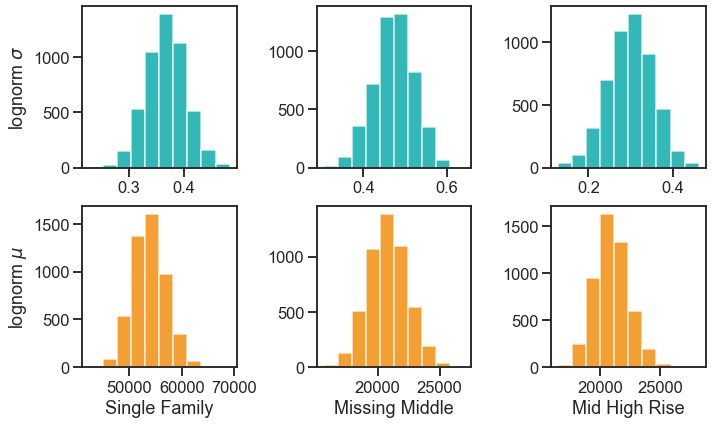

In [352]:
# plot
np.array(lmh_fits[0])[:,2]

fig, ax = plt.subplots(2,3, figsize=(10,6))

for i, form in enumerate(Simr.lmh):
    form_fits = lmh_fits[i]

    ax[0,i].hist(form_fits[:,0], color='#00A6A6', alpha=0.8)
    ax[1,i].hist(form_fits[:,2], color='#F08700', alpha=0.8)

    ax[1,i].set_xlabel(form)
ax[0,0].set_ylabel('lognorm $\sigma$')
ax[1,0].set_ylabel('lognorm $\mu$')

plt.tight_layout()
#plt.savefig('input_uncertainty.png', bbox_inches='tight')

## Random effects model:
Find the input uncertainty and compare to estimation error effect for $P(\theta > \tau_{2030})$ using fixed effect model $\theta_{i,j} = \mu(\hat{\theta_i}^\star) + \epsilon_{i,j}$ <br>
The simulation takes input data and fits it in a dataframe format; I could try re-coding the simulation a bit, or I could take the boostraps and put them into a pd format before passing to simulation. Either way it is a bit of extra work/compute time.
Recreate the mle fit object using the boostrap and pass it directly into the simulation:

In [235]:
embodied_params_i = Simr.embodied_fitter_mle(data=Simr.e_data.loc[Simr.e_data['year']==Simr.year], 
                                             distribution=Simr.e_distribution)
print(embodied_params_i)

def return_params_rem(lmh_fit_mat, i):
    """returns mle dict to pass into simulation for replication i."""
    params_rem = {}
    params_rem['Single Family'] = lmh_fit_mat[0][i]
    params_rem['Missing Middle'] = lmh_fit_mat[1][i]
    params_rem['Mid High Rise'] = lmh_fit_mat[2][i]
    return params_rem

return_params_rem(lmh_fits, 1)

{'Single Family': (0.34156471599981747, -4850.417863726592, 59012.66527888997), 'Missing Middle': (0.39344212087064473, -4153.83861988527, 25351.162062136536), 'Mid High Rise': (0.40317545678411815, 4651.679507032197, 15973.554882754557)}


{'Single Family': array([3.54983344e-01, 0.00000000e+00, 6.25808225e+04]),
 'Missing Middle': array([4.85799868e-01, 0.00000000e+00, 1.94619902e+04]),
 'Mid High Rise': array([3.43493338e-01, 0.00000000e+00, 2.36130656e+04])}

In [236]:
lmh_fits[0]

array([[3.87395289e-01, 0.00000000e+00, 5.39842384e+04],
       [3.54983344e-01, 0.00000000e+00, 6.25808225e+04],
       [3.38473060e-01, 0.00000000e+00, 5.56836108e+04],
       ...,
       [3.67745512e-01, 0.00000000e+00, 4.92664461e+04],
       [3.66129814e-01, 0.00000000e+00, 5.34072174e+04],
       [3.44946168e-01, 0.00000000e+00, 6.04905090e+04]])

Single-year simulation function modified to take in boostrapped inputs

In [226]:
# single year using the simulation object
def single_year_simulation(b, b_cumulative, embodied_params_bootstrap):
    """
    Will calculate the emissions for self.year
    including cumulative operational emissions.
    b = houses built in year y
    b_cumulative = houses built in years 1->y
    """
    # ---FIT INPUT DATA---
    # MLE for embodied, factor for operational
    #embodied_params_i = Simr.embodied_fitter_mle(data=Simr.e_data.loc[Simr.e_data['year']==Simr.year], 
    #                                                distribution=Simr.e_distribution)
    embodied_params_i = embodied_params_bootstrap
    operational_factor_i = Simr.get_operational_factor(operational_df=Simr.o_data, 
                                                        year=Simr.year)

    # get the number of starts for each housing type in 2030
    n_lmh_2030 = Simr.split_n_lmh(n=b, l=Simr.nlmh[0], m=Simr.nlmh[1], h=Simr.nlmh[2])
    # get the cumulative starts to 2030
    n_lmh_2030_cumulative = Simr.split_n_lmh(n=b_cumulative, l=Simr.nlmh[0], m=Simr.nlmh[1], h=Simr.nlmh[2])


    # ---SIMULATE: BUILD HOUSES, CALC PERFORMANCE VARIABLES---
    # embodied emissions for the given year
    embodied_i = Simr.build_embodied_lmh(n=b, e_params_dict=embodied_params_i,
                                            distribution=Simr.e_distribution,
                                            l=Simr.nlmh[0], m=Simr.nlmh[1], h=Simr.nlmh[2])

    # operational emissions of cumulative houses built
    operational_i = Simr.build_operational_lmh(n=b_cumulative, o_factor_dict=operational_factor_i,
                                                l=Simr.nlmh[0], m=Simr.nlmh[1], h=Simr.nlmh[2])

    # ---STORE OUTPUTS---
    # full data
    raw = {'year':Simr.year,
                'embodied':embodied_i, 
                'operational_y':operational_i,
                'num_built':n_lmh_2030_cumulative}

    # emissions each year
    embodied = embodied_i['Single Family']+embodied_i['Missing Middle']+embodied_i['Mid High Rise']
    operational = operational_i['Single Family']+operational_i['Missing Middle']+operational_i['Mid High Rise']

    # number built
    built = n_lmh_2030_cumulative['Single Family'] + n_lmh_2030_cumulative['Missing Middle'] + n_lmh_2030_cumulative['Mid High Rise']

    return {'raw':raw, 'E_e':embodied, 'E_o':operational, 'B':built}

Run the random effects model algorithm

In [250]:
input_replications = 50
sim_replications = 500
np.random.seed(Simr.seed)

# boostrap sample fits were precalculate above using same random seed, we just have to get the specific
# one for our replication.
ij_thetas = []
for i in range(input_replications):
    params_i = return_params_rem(lmh_fits, i)
    print('boostrap iter:', i)

    # simulation iterations
    j_thetas = []
    for j in range(sim_replications):
        # housing sample paths
        b_2030 = starts_data_hg10.loc[j,'2030'].astype(int)
        b_2030_cum = starts_data_hg10.loc[j,'2023':'2030'].values.sum().astype(int)

        # simulation
        emit = single_year_simulation(b_2030, b_2030_cum, params_i)
        j_thetas.append(emit['E_e']*1e-9 + emit['E_o']*1e-9)

    ij_thetas.append(j_thetas)

boostrap iter: 0
boostrap iter: 1
boostrap iter: 2
boostrap iter: 3
boostrap iter: 4
boostrap iter: 5
boostrap iter: 6
boostrap iter: 7
boostrap iter: 8
boostrap iter: 9
boostrap iter: 10
boostrap iter: 11
boostrap iter: 12
boostrap iter: 13
boostrap iter: 14
boostrap iter: 15
boostrap iter: 16
boostrap iter: 17
boostrap iter: 18
boostrap iter: 19
boostrap iter: 20
boostrap iter: 21
boostrap iter: 22
boostrap iter: 23
boostrap iter: 24
boostrap iter: 25
boostrap iter: 26
boostrap iter: 27
boostrap iter: 28
boostrap iter: 29
boostrap iter: 30
boostrap iter: 31
boostrap iter: 32
boostrap iter: 33
boostrap iter: 34
boostrap iter: 35
boostrap iter: 36
boostrap iter: 37
boostrap iter: 38
boostrap iter: 39
boostrap iter: 40
boostrap iter: 41
boostrap iter: 42
boostrap iter: 43
boostrap iter: 44
boostrap iter: 45
boostrap iter: 46
boostrap iter: 47
boostrap iter: 48
boostrap iter: 49


In [339]:
ij_thetas = np.array(ij_thetas)

tau = 26.4
ij_thetas_tau = np.int64(ij_thetas>tau)

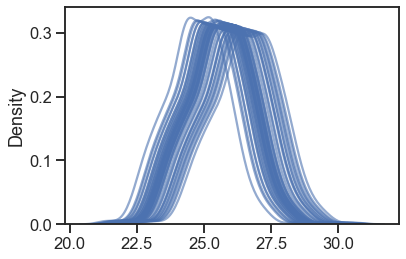

In [340]:
fig, ax = plt.subplots()
for ip in ij_thetas:
    sns.kdeplot(ip, ax=ax, color='b', alpha=0.6)

Calculate estimator of $\sigma_I^2$ vs the estimation error using $\sigma_T^2$ $\sigma_S^2$ on the MEAN of the cumulative emissions that year

In [343]:
n = sim_replications
b = input_replications

# calculate means across replications
theta_dotdot = ij_thetas.mean()
theta_idot = ij_thetas.mean(axis=1)

# calculate r-ef-model estimator sigmas
sigma_t = (n/(b-1))*np.sum((theta_idot - theta_dotdot)**2)
print('sigma t', sigma_t)

jvar = [np.sum((ij_thetas[i,:] - ij_thetas[i,:].mean())**2) for i in range(b)]
sigma_s = (1/(b*(n-1)))*np.array(jvar).sum()
print('sigma s', sigma_s)

# calculate input uncertainty
sigma_i = (sigma_t-sigma_s)/n
print('sigma i', sigma_i)

# ratio of input uncertainty
print('sigma_s/n: ', (sigma_s/n))
print('ratio of input relative to estimation uncertainty: ', sigma_i/(sigma_s/n))
print('standard error sigma_s: ', np.sqrt(sigma_s/n))

sigma t 96.07062018089162
sigma s 1.3432743781050922
sigma i 0.18945469160557307
sigma_s/n:  0.0026865487562101843
ratio of input relative to estimation uncertainty:  70.51972951082037
standard error sigma_s:  0.051831927961539154


The input uncertainty is ~70x higher than estimation error! though estimation error here is very low because... what does this look like on probability of overshoot and if the standard error of input uncertainty was used for a confidence interval?

In [351]:
n = sim_replications
b = input_replications

# calculate means across replications
theta_dotdot = ij_thetas_tau.mean()
theta_idot = ij_thetas_tau.mean(axis=1)

# calculate r-ef-model estimator sigmas
sigma_t = (n/(b-1))*np.sum((theta_idot - theta_dotdot)**2)
print('sigma t', sigma_t)

jvar = [np.sum((ij_thetas_tau[i,:] - ij_thetas_tau[i,:].mean())**2) for i in range(b)]
sigma_s = (1/(b*(n-1)))*np.array(jvar).sum()
print('sigma s', sigma_s)

# calculate input uncertainty
sigma_i = (sigma_t-sigma_s)/n
print('SIGMA I', sigma_i)

# ratio of input uncertainty
print('sigma_s/n: ', (sigma_s/n))
print('ratio of input relative to estimation uncertainty: ', sigma_i/(sigma_s/n))
print('standard error sigma_s: ', np.sqrt(sigma_s/n))
print('\n')
print('if input uncertainty was a halfwidth:', theta_dotdot, '+-', 1.96*np.sqrt(sigma_i/b))

sigma t 8.542939591836733
sigma s 0.19048921843687378
SIGMA I 0.01670490074679972
sigma_s/n:  0.00038097843687374754
ratio of input relative to estimation uncertainty:  43.84736544114584
standard error sigma_s:  0.01951866893191612


if input uncertainty was a halfwidth: 0.29228 +- 0.035825562580064474
